In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.3.0


In [2]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

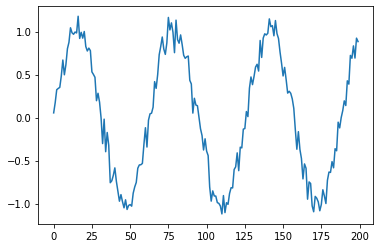

In [16]:
# make the original data
series = np.sin(0.1*np.arange(200)) + np.random.randn(200)*0.1

# plot it
plt.plot(series)
plt.show()

In [5]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1) # Now the data should be N x T x D
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990,)


In [6]:
### try autoregressive RNN model
i = Input(shape=(T, 1))
x = SimpleRNN(15, activation='relu')(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.001),
)

# train the RNN
r = model.fit(
  X[:-N//2], Y[:-N//2],
  epochs=80,
  validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
16/16 [==============================] - 0s 29ms/step - loss: 0.1986 - val_loss: 0.1467
Epoch 2/80
16/16 [==============================] - 0s 15ms/step - loss: 0.1108 - val_loss: 0.0719
Epoch 3/80
16/16 [==============================] - 0s 14ms/step - loss: 0.0490 - val_loss: 0.0288
Epoch 4/80
16/16 [==============================] - 0s 15ms/step - loss: 0.0189 - val_loss: 0.0111
Epoch 5/80
16/16 [==============================] - 0s 17ms/step - loss: 0.0088 - val_loss: 0.0061
Epoch 6/80
16/16 [==============================] - 0s 15ms/step - loss: 0.0046 - val_loss: 0.0035
Epoch 7/80
16/16 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/80
16/16 [==============================] - 0s 14ms/step - loss: 0.0012 - val_loss: 6.9749e-04
Epoch 9/80
16/16 [==============================] - 0s 15ms/step - loss: 4.3035e-04 - val_loss: 2.8309e-04
Epoch 10/80
16/16 [==============================] - 0s 14ms/step - loss: 2.2648e-04 - val_loss: 

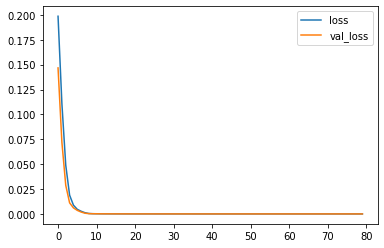

In [7]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [8]:
# "Wrong" forecast using true targets

validation_target = Y[-N//2:]
validation_predictions = []

# index of first validation input
i = -N//2

while len(validation_predictions) < len(validation_target):
  p = model.predict(X[i].reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  i += 1
  
  # update the predictions list
  validation_predictions.append(p)

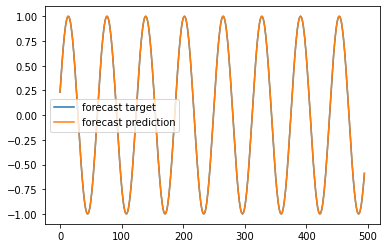

In [9]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [10]:
# Forecast future values (use only self-predictions for making future predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# first validation input
last_x = X[-N//2] # 1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, -1, 1))[0,0] # 1x1 array -> scalar
  
  # update the predictions list
  validation_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

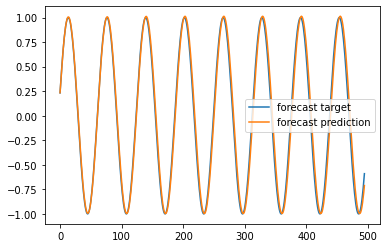

In [11]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()